In [1]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report
from flask import Flask, request, jsonify
import json
import subprocess
import time
import requests
import threading
import os

# Step 2: Load the dataset (Pima Indians Diabetes dataset)
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv'
df = pd.read_csv(url, header=None)

# Split data into features and target
X = df.iloc[:, :-1]
y = df.iloc[:, -1]

# Step 3: Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Build and train the Neural Network model
nn_model = Sequential([
    Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
nn_model.fit(X_train_scaled, y_train, epochs=20, batch_size=32, validation_split=0.2)

# Step 6: Train the RandomForest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Step 7: Evaluate both models
rf_preds = rf_model.predict(X_test_scaled)
nn_preds = (nn_model.predict(X_test_scaled) > 0.5).astype(int).flatten()
ensemble_preds = np.round((rf_preds + nn_preds) / 2)

# Evaluate the ensemble model
accuracy = accuracy_score(y_test, ensemble_preds)
print(f"Ensemble Model Accuracy: {accuracy * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test, ensemble_preds))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - accuracy: 0.6440 - loss: 0.6461 - val_accuracy: 0.6585 - val_loss: 0.6148
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7708 - loss: 0.5738 - val_accuracy: 0.6911 - val_loss: 0.5694
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7881 - loss: 0.5016 - val_accuracy: 0.7073 - val_loss: 0.5340
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7839 - loss: 0.4718 - val_accuracy: 0.7236 - val_loss: 0.5087
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7713 - loss: 0.4734 - val_accuracy: 0.7154 - val_loss: 0.4962
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7793 - loss: 0.4454 - val_accuracy: 0.7154 - val_loss: 0.4870
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7769 - loss: 0.4374 - val_accuracy: 0.7154 - val_loss: 0.4840
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7931 - loss: 0.4312 - val_accuracy: 0.7317 - val_loss

In [2]:
!pip install flask-ngrok
!pip install flask

In [4]:
# Step 1: Install ngrok and download the latest version
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvf ngrok-v3-stable-linux-amd64.tgz

# Step 2: Authenticate ngrok with your authtoken
# Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok auth token
!./ngrok authtoken 2nZx8wsUF3lnej4aQXarwRXCeiv_6UxAQhtkWDcoAbgbj3T8Y

# Step 3: Import necessary libraries
import subprocess
import json
import time
import requests
from flask import Flask, request, jsonify
import numpy as np
import threading

# Step 4: Start ngrok in the background and capture the public URL
def start_ngrok():
    # Run ngrok in the background
    ngrok_process = subprocess.Popen(['./ngrok', 'http', '5000'], stdout=subprocess.PIPE)
    time.sleep(5)  # Give ngrok a few seconds to initialize

    # Get the public URL from ngrok's API
    ngrok_url = requests.get('http://localhost:4040/api/tunnels').text
    ngrok_data = json.loads(ngrok_url)
    public_url = ngrok_data['tunnels'][0]['public_url']
    print(f"ngrok tunnel opened at: {public_url}")
    return public_url

public_url = start_ngrok()

# Step 5: Define and run the Flask app
app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    # Get the input data from the request
    data = request.json
    features = np.array([data['pregnancies'], data['glucose'], data['blood_pressure'],
                         data['skin_thickness'], data['insulin'], data['bmi'],
                         data['diabetes_pedigree'], data['age']]).reshape(1, -1)

    # Simple prediction logic (replace with your model's logic)
    # Example: Predict based on glucose level
    prediction = 'Diabetic' if features[0][1] > 120 else 'Not Diabetic'

    # Return prediction as JSON response
    return jsonify({
        'prediction': prediction
    })

# Run the Flask app in a separate thread to avoid blocking Colab
def run_flask():
    app.run()

# Step 6: Start Flask app in a background thread
thread = threading.Thread(target=run_flask)
thread.start()

# Step 7: Make a POST request to the Flask app via ngrok
# Now you can send requests to the public URL provided by ngrok
data = {
    "pregnancies": 2,
    "glucose": 140,
    "blood_pressure": 80,
    "skin_thickness": 20,
    "insulin": 85,
    "bmi": 25.0,
    "diabetes_pedigree": 0.5,
    "age": 40
}

# Send a POST request to the Flask app through ngrok
response = requests.post(f'{public_url}/predict', json=data)
print(response.json())  # This will print the prediction result from Flask

--2024-10-18 03:36:36--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 52.202.168.65, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|52.202.168.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9088051 (8.7M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz.1’

ngrok-v3-stable-lin 100%[===================>]   8.67M  6.74MB/s    in 1.3s    

2024-10-18 03:36:38 (6.74 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz.1’ saved [9088051/9088051]

ngrok
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
ngrok tunnel opened at: https://dfb4-34-169-46-63.ngrok-free.app
 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.
INFO:werkzeug:127.0.0.1 - - [18/Oct/2024 03:36:44] "POST /predict HTTP/1.1" 200 -


{'prediction': 'Diabetic'}


In [5]:
from IPython.core.display import display, HTML

# Define your HTML code as a string
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Diabetes Prediction</title>
</head>
<body>
    <h1>Diabetes Prediction</h1>
    <form id="predictionForm">
        <label for="pregnancies">Pregnancies:</label><br>
        <input type="text" id="pregnancies" name="pregnancies"><br>
        <label for="glucose">Glucose:</label><br>
        <input type="text" id="glucose" name="glucose"><br>
        <label for="blood_pressure">Blood Pressure:</label><br>
        <input type="text" id="blood_pressure" name="blood_pressure"><br>
        <label for="skin_thickness">Skin Thickness:</label><br>
        <input type="text" id="skin_thickness" name="skin_thickness"><br>
        <label for="insulin">Insulin:</label><br>
        <input type="text" id="insulin" name="insulin"><br>
        <label for="bmi">BMI:</label><br>
        <input type="text" id="bmi" name="bmi"><br>
        <label for="diabetes_pedigree">Diabetes Pedigree:</label><br>
        <input type="text" id="diabetes_pedigree" name="diabetes_pedigree"><br>
        <label for="age">Age:</label><br>
        <input type="text" id="age" name="age"><br><br>
        <input type="button" value="Predict" onclick="makePrediction()">
    </form>
    <p id="result"></p>
    <script>
        function makePrediction() {
            const formData = {
                pregnancies: document.getElementById('pregnancies').value,
                glucose: document.getElementById('glucose').value,
                blood_pressure: document.getElementById('blood_pressure').value,
                skin_thickness: document.getElementById('skin_thickness').value,
                insulin: document.getElementById('insulin').value,
                bmi: document.getElementById('bmi').value,
                diabetes_pedigree: document.getElementById('diabetes_pedigree').value,
                age: document.getElementById('age').value
            };
            fetch('/predict', {
                method: 'POST',
                headers: { 'Content-Type': 'application/json' },
                body: JSON.stringify(formData)
            })
            .then(response => response.json())
            .then(data => {
                document.getElementById('result').innerHTML = `
                    Prediction: ${data.prediction}<br>
                    Recommendation: ${JSON.stringify(data.recommendation)}
                `;
            });
        }
    </script>
</body>
</html>
"""

# Display the HTML code
display(HTML(html_code))

In [6]:
# Create an HTML file with the responsive form
html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Diabetes Prediction</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: #f4f4f4;
        }
        h1 {
            text-align: center;
            color: #333;
        }
        #predictionForm {
            display: flex;
            flex-direction: column;
            max-width: 600px;
            margin: auto;
            padding: 20px;
            background: white;
            border-radius: 5px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }
        label {
            margin: 10px 0 5px;
        }
        input[type="text"] {
            padding: 10px;
            margin-bottom: 15px;
            border: 1px solid #ccc;
            border-radius: 4px;
        }
        input[type="button"] {
            padding: 10px;
            background-color: #28a745;
            color: white;
            border: none;
            border-radius: 4px;
            cursor: pointer;
        }
        input[type="button"]:hover {
            background-color: #218838;
        }
        #result {
            margin-top: 20px;
            padding: 15px;
            background-color: #e9ecef;
            border-radius: 5px;
            text-align: center;
        }
        @media (max-width: 600px) {
            #predictionForm {
                width: 100%;
                padding: 15px;
            }
            input[type="button"] {
                width: 100%;
            }
        }
    </style>
</head>
<body>
    <h1>Diabetes Prediction</h1>
    <form id="predictionForm">
        <label for="pregnancies">Pregnancies:</label>
        <input type="text" id="pregnancies" name="pregnancies">
        <label for="glucose">Glucose:</label>
        <input type="text" id="glucose" name="glucose">
        <label for="blood_pressure">Blood Pressure:</label>
        <input type="text" id="blood_pressure" name="blood_pressure">
        <label for="skin_thickness">Skin Thickness:</label>
        <input type="text" id="skin_thickness" name="skin_thickness">
        <label for="insulin">Insulin:</label>
        <input type="text" id="insulin" name="insulin">
        <label for="bmi">BMI:</label>
        <input type="text" id="bmi" name="bmi">
        <label for="diabetes_pedigree">Diabetes Pedigree:</label>
        <input type="text" id="diabetes_pedigree" name="diabetes_pedigree">
        <label for="age">Age:</label>
        <input type="text" id="age" name="age">
        <input type="button" value="Predict" onclick="makePrediction()">
    </form>
    <p id="result"></p>
    <script>
        function makePrediction() {
            const formData = {
                pregnancies: document.getElementById('pregnancies').value,
                glucose: document.getElementById('glucose').value,
                blood_pressure: document.getElementById('blood_pressure').value,
                skin_thickness: document.getElementById('skin_thickness').value,
                insulin: document.getElementById('insulin').value,
                bmi: document.getElementById('bmi').value,
                diabetes_pedigree: document.getElementById('diabetes_pedigree').value,
                age: document.getElementById('age').value
            };
            fetch('/predict', {
                method: 'POST',
                headers: { 'Content-Type': 'application/json' },
                body: JSON.stringify(formData)
            })
            .then(response => response.json())
            .then(data => {
                document.getElementById('result').innerHTML = `
                    Prediction: ${data.prediction}<br>
                    Recommendation: ${JSON.stringify(data.recommendation)}
                `;
            });
        }
    </script>
</body>
</html>
"""

# Write the HTML code to an index.html file
with open('index.html', 'w') as f:
    f.write(html_code)

In [8]:
# Step 1: Install ngrok and download the latest version
!wget https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
!tar -xvf ngrok-v3-stable-linux-amd64.tgz

# Step 2: Authenticate ngrok with your authtoken
# Replace 'YOUR_NGROK_AUTH_TOKEN' with your actual ngrok auth token
!./ngrok authtoken 2nZx8wsUF3lnej4aQXarwRXCeiv_6UxAQhtkWDcoAbgbj3T8Y

html_code = """
<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Diabetes Prediction</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 20px;
            background-color: #f4f4f4;
        }
        h1 {
            text-align: center;
            color: #333;
        }
        #predictionForm {
            display: flex;
            flex-direction: column;
            max-width: 600px;
            margin: auto;
            padding: 20px;
            background: white;
            border-radius: 5px;
            box-shadow: 0 2px 10px rgba(0,0,0,0.1);
        }
        label {
            margin: 10px 0 5px;
        }
        input[type="text"] {
            padding: 10px;
            margin-bottom: 15px;
            border: 1px solid #ccc;
            border-radius: 4px;
        }
        input[type="button"] {
            padding: 10px;
            background-color: #28a745;
            color: white;
            border: none;
            border-radius: 4px;
            cursor: pointer;
        }
        input[type="button"]:hover {
            background-color: #218838;
        }
        #result {
            margin-top: 20px;
            padding: 15px;
            background-color: #e9ecef;
            border-radius: 5px;
            text-align: center;
        }
        @media (max-width: 600px) {
            #predictionForm {
                width: 100%;
                padding: 15px;
            }
            input[type="button"] {
                width: 100%;
            }
        }
    </style>
</head>
<body>
    <h1>Diabetes Prediction</h1>
    <form id="predictionForm">
        <label for="pregnancies">Pregnancies:</label>
        <input type="text" id="pregnancies" name="pregnancies">
        <label for="glucose">Glucose:</label>
        <input type="text" id="glucose" name="glucose">
        <label for="blood_pressure">Blood Pressure:</label>
        <input type="text" id="blood_pressure" name="blood_pressure">
        <label for="skin_thickness">Skin Thickness:</label>
        <input type="text" id="skin_thickness" name="skin_thickness">
        <label for="insulin">Insulin:</label>
        <input type="text" id="insulin" name="insulin">
        <label for="bmi">BMI:</label>
        <input type="text" id="bmi" name="bmi">
        <label for="diabetes_pedigree">Diabetes Pedigree:</label>
        <input type="text" id="diabetes_pedigree" name="diabetes_pedigree">
        <label for="age">Age:</label>
        <input type="text" id="age" name="age">
        <input type="button" value="Predict" onclick="makePrediction()">
    </form>
    <p id="result"></p>
    <script>
        function makePrediction() {
            const formData = {
                pregnancies: document.getElementById('pregnancies').value,
                glucose: document.getElementById('glucose').value,
                blood_pressure: document.getElementById('blood_pressure').value,
                skin_thickness: document.getElementById('skin_thickness').value,
                insulin: document.getElementById('insulin').value,
                bmi: document.getElementById('bmi').value,
                diabetes_pedigree: document.getElementById('diabetes_pedigree').value,
                age: document.getElementById('age').value
            };
            fetch('/predict', {
                method: 'POST',
                headers: { 'Content-Type': 'application/json' },
                body: JSON.stringify(formData)
            })
            .then(response => response.json())
            .then(data => {
                document.getElementById('result').innerHTML = `
                    Prediction: ${data.prediction}<br>
                    Recommendation: ${JSON.stringify(data.recommendation)}
                `;
            });
        }
    </script>
</body>
</html>
"""

# Write the HTML code to an index.html file
with open('index.html', 'w') as f:
    f.write(html_code)

# Check if the file was created successfully
if os.path.exists('index.html'):
    print("HTML file created successfully.")
else:
    print("HTML file not found.")


--2024-10-18 03:37:31--  https://bin.equinox.io/c/bNyj1mQVY4c/ngrok-v3-stable-linux-amd64.tgz
Resolving bin.equinox.io (bin.equinox.io)... 54.161.241.46, 54.237.133.81, 18.205.222.128, ...
Connecting to bin.equinox.io (bin.equinox.io)|54.161.241.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9088051 (8.7M) [application/octet-stream]
Saving to: ‘ngrok-v3-stable-linux-amd64.tgz.2’

ngrok-v3-stable-lin 100%[===================>]   8.67M  13.8MB/s    in 0.6s    

2024-10-18 03:37:33 (13.8 MB/s) - ‘ngrok-v3-stable-linux-amd64.tgz.2’ saved [9088051/9088051]

ngrok
Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
HTML file created successfully.


In [9]:
# Step 12: Start ngrok in the background and capture the public URL
def start_ngrok():
    # Run ngrok in the background
    ngrok_process = subprocess.Popen(['./ngrok', 'http', '5000'], stdout=subprocess.PIPE)
    time.sleep(5)  # Give ngrok a few seconds to initialize

    # Get the public URL from ngrok's API
    ngrok_url = requests.get('http://localhost:4040/api/tunnels').text
    ngrok_data = json.loads(ngrok_url)
    public_url = ngrok_data['tunnels'][0]['public_url']
    print(f"ngrok tunnel opened at: {public_url}")
    return public_url

public_url = start_ngrok()

ngrok tunnel opened at: https://dfb4-34-169-46-63.ngrok-free.app


In [11]:
# Step 13: Define and run the Flask app
app = Flask(__name__)

@app.route('/')
def home():
    return send_from_directory('.', 'index.html')  # Serve the HTML file

@app.route('/predict', methods=['POST'])
def predict():
    # Get the input data from the request
    data = request.json
    features = np.array([data['pregnancies'], data['glucose'], data['blood_pressure'],
                         data['skin_thickness'], data['insulin'], data['bmi'],
                         data['diabetes_pedigree'], data['age']]).reshape(1, -1)

    # Scale the features
    features_scaled = scaler.transform(features)

    # Get predictions from both models
    rf_pred = rf_model.predict(features_scaled)
    nn_pred = (nn_model.predict(features_scaled) > 0.5).astype(int).flatten()

    # Ensemble prediction
    final_pred = np.round((rf_pred + nn_pred) / 2)[0]

    # Recommendation based on prediction
    if final_pred == 1:
        recommendation = {
            'exercise': '30 mins daily of regular exercise',
            'diet': 'Low sugar balanced diet'
        }
    else:
        recommendation = {
            'recommendation': 'Maintain regular weight and healthy habits'
        }

    return jsonify({
        'prediction': 'Diabetic' if final_pred == 1 else 'Not Diabetic',
        'recommendation': recommendation
    })

# Step 14: Run the Flask app in a separate thread
def run_flask():
    app.run(port=5001)  # Use the default port 5000

# Step 15: Start Flask app in a background thread
thread = threading.Thread(target=run_flask)
thread.start()

# You can now use the public URL provided by ngrok to access the app.

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5001
INFO:werkzeug:Press CTRL+C to quit


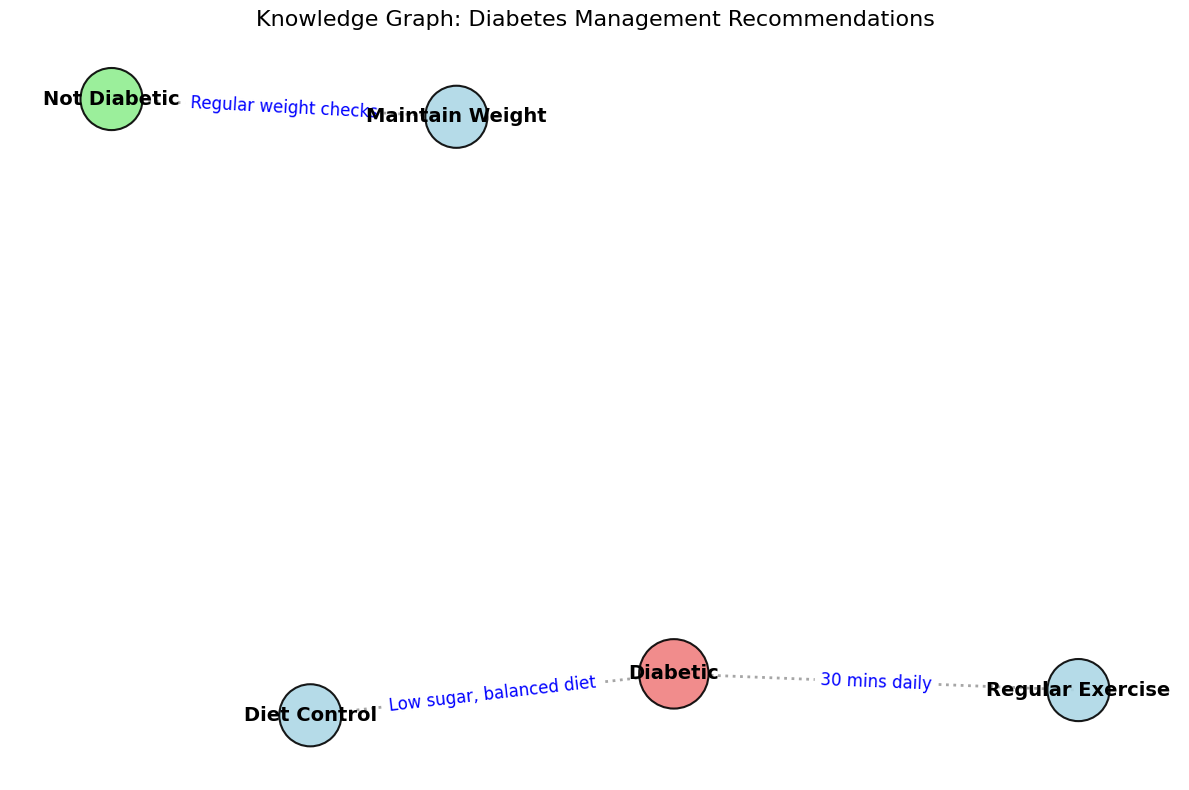

In [12]:
import matplotlib.pyplot as plt
import networkx as nx

# Function to visualize the knowledge graph
def visualize_graph():
    G = nx.Graph()

    # Add edges with recommendations for diabetes management
    G.add_edge('Diabetic', 'Regular Exercise', recommendation='30 mins daily')
    G.add_edge('Diabetic', 'Diet Control', recommendation='Low sugar, balanced diet')
    G.add_edge('Not Diabetic', 'Maintain Weight', recommendation='Regular weight checks')

    # Define node colors based on their type
    node_colors = []
    for node in G.nodes():
        if node == 'Diabetic':
            node_colors.append('lightcoral')  # Color for Diabetic
        elif node == 'Not Diabetic':
            node_colors.append('lightgreen')  # Color for Not Diabetic
        else:
            node_colors.append('lightblue')  # Default color for other nodes

    # Set node size based on their importance
    node_size = [2500 if node == 'Diabetic' else 2000 for node in G.nodes()]

    pos = nx.spring_layout(G, seed=42, k=0.5)  # Layout for the graph with a fixed seed for reproducibility
    labels = nx.get_edge_attributes(G, 'recommendation')  # Get edge labels for recommendations

    plt.figure(figsize=(12, 8))  # Set a larger figure size

    # Draw nodes with specific sizes and colors
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_colors, alpha=0.9, edgecolors='black', linewidths=1.5)

    # Draw edges with distinct styles
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.7, edge_color='gray', style='dotted')

    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold', font_color='black')  # Corrected parameter

    # Draw edge labels with recommendations
    nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='blue', font_size=12)

    plt.title("Knowledge Graph: Diabetes Management Recommendations", fontsize=16)
    plt.axis('off')  # Turn off the axis
    plt.grid(False)  # Disable grid
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the graph

# Call the function to display the enhanced graph
visualize_graph()